In [2]:
# Dependencies
import numpy as np
import pandas as pd
import datetime as dt
import requests
import json

from pprint import pprint
from matplotlib import style
import matplotlib.pyplot as plt


# Extract: Data Pull

## Extract Data & Clean

### API Tracking data from CDC

#### Max temp days

In [3]:
# URL for GET requests to retrieve data
version = "v1"
measureId = 423 # Requires a valid measureID
stratificationLevelId = 82 # Requires a valid stratificationLevelId.
geographicTypeIdFilter = 1 # Requires a valid geographicTypeID or ALL.
geographicItemsFilter = 4 # Filter to retrieve only certain geographicItems.
temporalTypeIdFilter = 1 # Requires a valid temporal type id matching temporal items (e.g., 1)
temporalItemsFilter = "2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011" # Requires valid temporal items entries (e.g., 2020) separated by comma.
isSmoothed = 0 # 0 not smoothed- most data isn't
getFullCoreHolder = 0 # Requires either a one or zero (true or false) for fetching the full core holder. 


# Build the endpoint URL
MaxTempDays_url = f"https://ephtracking.cdc.gov/apigateway/api/{version}/getCoreHolder/{measureId}/{stratificationLevelId}/{geographicTypeIdFilter}/{geographicItemsFilter}/{temporalTypeIdFilter}/{temporalItemsFilter}/{isSmoothed}/{getFullCoreHolder}?TemperatureHeatIndexId=1&RelativeThresholdId=1" #{getFullCoreHolder}

response = requests.get(MaxTempDays_url).json()

# Isolate tableResult for easy reading
data = response["tableResult"]

#for index, element in enumerate(data):
#  print(index, ":", element)

In [4]:
# Create an empty list to hold summaries
summary_list = []

# loop through the data
for bob in data:
    county = bob["geo"]
    countyID= bob["geoId"]
    year = bob["temporal"]
    days = bob["dataValue"]
    
    # create summary dictionary
    summary_dict = {
        "county": county,
        "countyID" : countyID,
        "year": year,
        "ext_heat_days" : days
    }
    
    # Append the sumary dict to the list
    summary_list.append(summary_dict)

EHD = pd.DataFrame(summary_list) 
EHD

,county,countyID,year,ext_heat_days
0,Apache,04001,2011,19
1,Apache,04001,2012,19
2,Apache,04001,2013,18
3,Apache,04001,2014,5
4,Apache,04001,2015,18
...,...,...,...,...
160,Yuma,04027,2017,21
161,Yuma,04027,2018,19
162,Yuma,04027,2019,22
163,Yuma,04027,2020,36


In [5]:
EHD = EHD.reset_index()
EHD.head()

,index,county,countyID,year,ext_heat_days
0,0,Apache,04001,2011,19
1,1,Apache,04001,2012,19
2,2,Apache,04001,2013,18
3,3,Apache,04001,2014,5
4,4,Apache,04001,2015,18


In [6]:
EHD.rename(columns={'index':'key'}, inplace=True)
EHD.head()

,key,county,countyID,year,ext_heat_days
0,0,Apache,04001,2011,19
1,1,Apache,04001,2012,19
2,2,Apache,04001,2013,18
3,3,Apache,04001,2014,5
4,4,Apache,04001,2015,18


In [7]:
# Export the cleaned DataFrame as a CSV file. 
EHD.to_csv("data/ExtremeHeatDays.csv", encoding='utf8', index=False)

## CSV to JSON files

In [8]:
from json import loads, dumps

In [9]:
df = EHD

In [10]:
# Use DataFrame.to_json() to orient = 'columns' 
df2 = df.to_json(orient = 'records')
pprint(df2)


('[{"key":0,"county":"Apache","countyID":"04001","year":"2011","ext_heat_days":"19"},{"key":1,"county":"Apache","countyID":"04001","year":"2012","ext_heat_days":"19"},{"key":2,"county":"Apache","countyID":"04001","year":"2013","ext_heat_days":"18"},{"key":3,"county":"Apache","countyID":"04001","year":"2014","ext_heat_days":"5"},{"key":4,"county":"Apache","countyID":"04001","year":"2015","ext_heat_days":"18"},{"key":5,"county":"Apache","countyID":"04001","year":"2016","ext_heat_days":"16"},{"key":6,"county":"Apache","countyID":"04001","year":"2017","ext_heat_days":"16"},{"key":7,"county":"Apache","countyID":"04001","year":"2018","ext_heat_days":"31"},{"key":8,"county":"Apache","countyID":"04001","year":"2019","ext_heat_days":"23"},{"key":9,"county":"Apache","countyID":"04001","year":"2020","ext_heat_days":"38"},{"key":10,"county":"Apache","countyID":"04001","year":"2021","ext_heat_days":"24"},{"key":11,"county":"Cochise","countyID":"04003","year":"2011","ext_heat_days":"34"},{"key":12,"

# Load: SQLite database

In [11]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, distinct

# Import modules to declare columns and column data types
from sqlalchemy import Column, Integer, String, Float, Boolean

from pathlib import Path

In [12]:
Path('data/hri.sqlite').touch()

In [13]:
# create engine to HRI.sqlite
engine = create_engine("sqlite:///data/hri.sqlite")

In [14]:
engine.execute('''CREATE TABLE extreme_heat_days (key int PRIMARY KEY, county text, countyID int, year text, ext_heat_days int)''')

C:\Users\Noell\AppData\Local\Temp\ipykernel_8652\1858934895.py:1: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  engine.execute('''CREATE TABLE extreme_heat_days (key int PRIMARY KEY, county text, countyID int, year text, ext_heat_days int)''')


OperationalError: (sqlite3.OperationalError) table extreme_heat_days already exists
[SQL: CREATE TABLE extreme_heat_days (key int PRIMARY KEY, county text, countyID int, year text, ext_heat_days int)]
(Background on this error at: https://sqlalche.me/e/14/e3q8)

In [ ]:
# load the data into a Pandas DataFrame and write to sqlite table
extreme_heat_days = pd.read_csv('data/ExtremeHeatDays.csv')
extreme_heat_days.to_sql('extreme_heat_days', engine, if_exists='append', index = False)

165

In [15]:
# Reflect Database into ORM classes
Base = automap_base()
Base.prepare(autoload_with=engine)
Base.classes.keys() #['ed_visit_35', 'extreme_heat_days']

['extreme_heat_days']

In [16]:
ExHt = Base.classes.extreme_heat_days

# Building Queries from SQLite database
These queries will them be used in the flask but need to check to see if they work

In [17]:
# Create our session (link) from Python to the DB
session = Session(engine)

inspector = inspect(engine)

In [18]:
columns = inspector.get_columns('extreme_heat_days')
for column in columns:
    print(column["name"], column["type"])

key INTEGER
county TEXT
countyID INTEGER
year TEXT
ext_heat_days INTEGER


In [19]:
# Total years
session.query(func.count(ExHt.year)).all()

[(165,)]

### Query All

In [20]:
Base.metadata.create_all(engine)

In [21]:
all_list = session.query(ExHt)

all_list

In [22]:
All_ehd = session.query(ExHt.key, ExHt.county, ExHt.year, ExHt.ext_heat_days).\
    order_by(ExHt.county).all()
    
pprint(All_ehd)

[(0, 'Apache', '2011', 19),
 (1, 'Apache', '2012', 19),
 (2, 'Apache', '2013', 18),
 (3, 'Apache', '2014', 5),
 (4, 'Apache', '2015', 18),
 (5, 'Apache', '2016', 16),
 (6, 'Apache', '2017', 16),
 (7, 'Apache', '2018', 31),
 (8, 'Apache', '2019', 23),
 (9, 'Apache', '2020', 38),
 (10, 'Apache', '2021', 24),
 (11, 'Cochise', '2011', 34),
 (12, 'Cochise', '2012', 25),
 (13, 'Cochise', '2013', 19),
 (14, 'Cochise', '2014', 4),
 (15, 'Cochise', '2015', 14),
 (16, 'Cochise', '2016', 19),
 (17, 'Cochise', '2017', 17),
 (18, 'Cochise', '2018', 18),
 (19, 'Cochise', '2019', 26),
 (20, 'Cochise', '2020', 35),
 (21, 'Cochise', '2021', 16),
 (22, 'Coconino', '2011', 17),
 (23, 'Coconino', '2012', 20),
 (24, 'Coconino', '2013', 16),
 (25, 'Coconino', '2014', 4),
 (26, 'Coconino', '2015', 19),
 (27, 'Coconino', '2016', 17),
 (28, 'Coconino', '2017', 16),
 (29, 'Coconino', '2018', 28),
 (30, 'Coconino', '2019', 22),
 (31, 'Coconino', '2020', 36),
 (32, 'Coconino', '2021', 22),
 (33, 'Gila', '2011', 3

In [23]:
# List of unique counties
counties = session.query(ExHt.county).distinct().all()
all_counties = list(np.ravel(counties))

In [26]:
all_query_values = []

# Create list with column names
cNames= ["key", "county", "year", "ext_heat_days"]

# enumerate- returns index & element
for index, element in All_ehd:
    my_dict = {}
    
    for index1, element1 in enumerate(cNames):
        my_dict[element1] = element[index1]
        
    all_query_values.append(my_dict)

all_query_values

ValueError: too many values to unpack (expected 2)

In [63]:
# This results in error: Object of type Row is not JSON serializable

<class 'list'> of type <class 'tuple'>


## Query Apache

In [ ]:
### Get Apache data 
Apache_ehd = session.query(ExHt.year, ExHt.ext_heat_days ).\
    filter(ExHt.county == 'Apache').\
    order_by(ExHt.year).all()

pprint(Apache_ehd)

[('2011', 19),
 ('2012', 19),
 ('2013', 18),
 ('2014', 5),
 ('2015', 18),
 ('2016', 16),
 ('2017', 16),
 ('2018', 31),
 ('2019', 23),
 ('2020', 38),
 ('2021', 24)]


In [ ]:
Apache_query_values = []

for year in Apache_ehd:
        ehd_dict = {}
        ehd_dict["year"] = year
        Apache_query_values.append(ehd_dict)

In [ ]:
    # precip analysis to a dictionary using date as the key and prcp as the value.
Apache_query_values = []
for two, one in Apache_ehd:
        Apache_EHD_dict = {}
        Apache_EHD_dict["Year"] = two
        Apache_EHD_dict["Extreme Heat Days"] = one

        Apache_query_values.append(Apache_EHD_dict)

In [ ]:
Apache_query_values

[{'Year': '2011', 'Extreme Heat Days': 19},
 {'Year': '2012', 'Extreme Heat Days': 19},
 {'Year': '2013', 'Extreme Heat Days': 18},
 {'Year': '2014', 'Extreme Heat Days': 5},
 {'Year': '2015', 'Extreme Heat Days': 18},
 {'Year': '2016', 'Extreme Heat Days': 16},
 {'Year': '2017', 'Extreme Heat Days': 16},
 {'Year': '2018', 'Extreme Heat Days': 31},
 {'Year': '2019', 'Extreme Heat Days': 23},
 {'Year': '2020', 'Extreme Heat Days': 38},
 {'Year': '2021', 'Extreme Heat Days': 24}]

In [ ]:
    # precip analysis to a dictionary using date as the key and prcp as the value.
Apache_query_values1 = []
for ext_heat_days, year in Apache_ehd:
        Apache_EHD_dict = {}

        Apache_EHD_dict["Year"] = year
        Apache_EHD_dict["Extreme Heat Days"] = ext_heat_days

        Apache_query_values1.append(Apache_EHD_dict)

In [ ]:
Apache_query_values1

[{'Year': 19, 'Extreme Heat Days': '2011'},
 {'Year': 19, 'Extreme Heat Days': '2012'},
 {'Year': 18, 'Extreme Heat Days': '2013'},
 {'Year': 5, 'Extreme Heat Days': '2014'},
 {'Year': 18, 'Extreme Heat Days': '2015'},
 {'Year': 16, 'Extreme Heat Days': '2016'},
 {'Year': 16, 'Extreme Heat Days': '2017'},
 {'Year': 31, 'Extreme Heat Days': '2018'},
 {'Year': 23, 'Extreme Heat Days': '2019'},
 {'Year': 38, 'Extreme Heat Days': '2020'},
 {'Year': 24, 'Extreme Heat Days': '2021'}]

In [ ]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
Apache_ehd = pd.DataFrame(Apache_ehd, columns = ["Year", "Number Extreme Heat Days"])

In [ ]:
# Sort the dataframe by date
Apache_ehd = Apache_ehd.sort_values(by=["Year"])
Apache_ehd

,Year,Number Extreme Heat Days
0,2011,19
1,2012,19
2,2013,18
3,2014,5
4,2015,18
5,2016,16
6,2017,16
7,2018,31
8,2019,23
9,2020,38


In [ ]:
Apache_ehd.dtypes

Year                        object
Number Extreme Heat Days     int64
dtype: object

In [ ]:
Apache_ehd['Year'] = Apache_ehd['Year'].astype('int')
Apache_ehd.set_index('Year', inplace=True)

In [ ]:
Apache_ehd

,Number Extreme Heat Days
Year,
2011,19
2012,19
2013,18
2014,5
2015,18
2016,16
2017,16
2018,31
2019,23


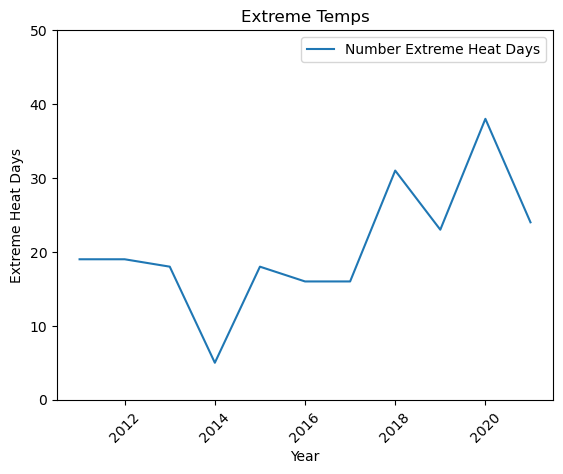

In [83]:
# Use Pandas Plotting with Matplotlib to plot the data
## Create the first bar chart with the Pandas DataFrame.plot() method.
apache_plot  = Apache_ehd.plot(ylim=(0,50), title = "Extreme Temps", rot = 45)

# Give our chart some labels and a tile
apache_plot.set_xlabel("Year")
apache_plot.set_ylabel("Extreme Heat Days")

#plt.savefig("Images/precipitation_bar.png")
plt.show()

In [69]:
# But we want the user to select the county

In [ ]:
# All data into list
